In [1]:
using LinearAlgebra
include("plotting.jl")
include("meshing.jl")
nothing

In [2]:
stiffness_element(lx, ly) =
[lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx
 lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx]

mass_element(lx, ly) = (lx * ly) / 6.0 *
[ 2. 0 -1  0
  0  2  0 -1
 -1  0  2  0
  0 -1  0  2]

# WARNING: works ONLY for x̂ normal direction!
abc(x̂) = (ly) *
[ 0. 0  0  0
  0  1  0  0
  0  0  0  0
  0  0  0  1]


abc (generic function with 1 method)

In [3]:
# Circuit
Rs =   1e+4 # Ω
RL = 2*13.2 # Ω

# Parameters
Δt = 0.05e-9
ε0 = 8.854e-12
μ0 = 4e-7π
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr
η  = sqrt(μ / ε)

n̂  = x̂ = [1.0, 0.0]
nothing

In [4]:
a, b = 2.00, 0.08
n, m = 200, 4
lx = a / n
ly = b / m
el2ed, el2edd = quadmesh(a, b, n, m);

In [5]:
DOF_NONE = 0
DOF_PEC  = 1
DOF_SRC  = 2
DOF_ABC  = 3
DOF_LOAD = 4
DOF_SG   = 5

function dof_type(n, m)
    global NUM_EDGES
    N = NUM_EDGES
    h = [  1+(2n+1)i: n+0+(2n+1)i for i=0:m]
    v = [n+1+(2n+1)i:2n+1+(2n+1)i for i=0:m-1]
    start, stop = extrema(h[3])
    h[3] = start:stop - 5
    
    dof_flag = zeros(Int64, N)
    
    dof_flag[(h[1])] .= DOF_PEC # BOTTOM
    dof_flag[(h[3])] .= DOF_PEC # MIDDLE
    dof_flag[(h[5])] .= DOF_PEC # TOP
    
    dof_flag[first(v[1])] = DOF_SRC
    dof_flag[first(v[2])] = DOF_SRC
    
    dof_flag[first(v[3])] = DOF_SG
    dof_flag[first(v[4])] = DOF_SG
    
    dof_flag[ last(v[1])] = DOF_LOAD
    dof_flag[ last(v[2])] = DOF_LOAD
    dof_flag[ last(v[3])] = DOF_LOAD
    dof_flag[ last(v[4])] = DOF_LOAD
    
    return dof_flag
end

dof_type (generic function with 1 method)

In [6]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(n, m)
f = Γ .!= DOF_PEC
NUM_DOFS = NUM_EDGES;

In [7]:
using SparseArrays
# ASSUMPTION: Waveguide is homogenous
# Assemble stiffness and mass matrices
S = spzeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
R = spzeros(NUM_DOFS, NUM_DOFS) # μ0 σ ∫( ∇Ni ⋅ ∇Nj )dΩ
T = spzeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ
B = spzeros(NUM_DOFS, NUM_DOFS) # μ0/η ∫(( n̂ × ∇Ni ) ⋅ ( n̂ × ∇Nj ))dΓ

# ASSUMPTION: Waveguide is homogenous
for ielem = 1:NUM_ELEMS # Assemble by elements
  Se = stiffness_element(lx, ly)
  Te = mass_element(lx, ly)
  Be = abc(n̂) # works only for x̂ normal direction
  
  for jedge = 1:4
    dj = el2edd[ielem, jedge]
    jj = dof[el2ed[ielem, jedge]]
    if jj == 0
      continue
    end
    
    for kedge = 1:4
      dk = el2edd[ielem, kedge]
      kk = dof[el2ed[ielem, kedge]]
      if kk == 0
        continue
      end

      S[jj, kk] = S[jj, kk] + dj * dk * (1/μr) * Se[jedge, kedge]
      T[jj, kk] = T[jj, kk] + dj * dk * (μ0*ε) * Te[jedge, kedge]
            
    
      if Γ[jj] == DOF_ABC
        B[jj, kk] = B[jj, kk] + (μ0/η) * dj * dk * Be[jedge, kedge]
      end
    end
  end
end

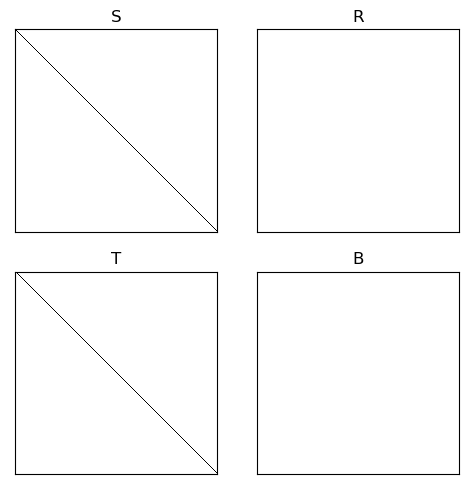

In [8]:
using PyPlot
figure(figsize=(5, 5))
subplot(2, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(2, 2, 2); spy(R); title("R"); xticks([]); yticks([]);
subplot(2, 2, 3); spy(T); title("T"); xticks([]); yticks([]);
subplot(2, 2, 4); spy(B); title("B"); xticks([]); yticks([]);
tight_layout()

In [9]:
A  = (+0.25Δt^2 * S +  T + 0.5Δt * B + 0.5Δt * R)
for ii = 1:NUM_EDGES
  if Γ[ii] == DOF_PEC
        A[:,dof[ii]].= 0.0
        A[dof[ii],:].= 0.0
        A[dof[ii], dof[ii]] = 1.0
  end
end

In [10]:
sigmoid(x) = 1.0 / (1.0 + exp(-5x))
Rsp(t, tswitch) = 1e15 - 1e15sigmoid(t - tswitch) + 6e-1

function assemble_circuit!(i, didv, v, t)
    for ii = 1:NUM_EDGES
        jj = dof[ii]
        if Γ[ii] == DOF_SG
            #y = step!(copy(D1), -v[jj] + Dual(0., 1.))
            #i[jj], didv[jj, jj] = value(y), partials(y)
            i[jj] = v[jj] * 1.0 / Rsp(1e9t, 15_000) * (b / ly)
            didv[jj, jj] =  1.0 / Rsp(1e9t, 15_000) * (b / ly)
        end

        if Γ[ii] == DOF_SRC
            i[jj] = v[jj] * 1.0 / Rs * (b / ly)
            didv[jj, jj] =  1.0 / Rs * (b / ly)
        end

        if Γ[ii] == DOF_LOAD
            i[jj] = v[jj] * 1.0 / RL * (b / ly)
            didv[jj, jj] =  1.0 / RL * (b / ly)
        end
    end
end
#ts = 1e9Δt * collect(1:nt)
#xlabel("time (ns)")
#plot(ts, Rsp.(ts, 15), "r.-")
#ylabel("Resistance (Ω)")

assemble_circuit! (generic function with 1 method)

In [11]:
using JLD2

x = 0.010:0.050:0.51
y = 0.005:0.012:0.07
xx, yy = meshgrid(x, y);

it  = 1
nt  = 3*500
t   = 0.00 + 15000e-9
e   = zeros(NUM_EDGES)
i   = zeros(NUM_EDGES)

e0  = zeros(NUM_EDGES)
ep  = zeros(NUM_EDGES)
epp = zeros(NUM_EDGES)
ip  = zeros(NUM_EDGES)
ipp = zeros(NUM_EDGES)

e0 .= load("blumlein-e0-$n-$m-$a-$b.jld2", "e0")
ep .= e0
epp.= e0

didv = spzeros(NUM_EDGES, NUM_EDGES)
res = zeros(nt, 11, 6, 2)
vRsg = zeros(nt)
vRL  = zeros(nt)
nothing

In [12]:
N = 0
Δe = similar(e)
@elapsed for _ = it:nt
    bi = (0.50Δt^2 * S - 2T) * ep + (0.25Δt^2 * S +  T - 0.5Δt * B - 0.5Δt * R) * epp
    
    fill!(Δe, Inf)
    while norm(Δe) > 1e-12 && N < 10
        assemble_circuit!(i, didv, e, t)
        Fi = A*e + 0.5Δt * ly^2 * μ0 * i - 0.5Δt * ly^2 * μ0 * ipp + bi
        Ji = A   + 0.5Δt * ly^2 * μ0 * didv
        Δe .= Ji\Fi
        e .-= Δe
        N += 1
    end
    println("[linear] $it [nonlinear] converged in $N iterations with $(norm(Δe))")
    N = 0
    
    epp .= ep
    ep  .= e

    ipp .= ip
    ip  .= i
    
    res[it, :, :, :] .= evaluate(WhitneyRectangleElement(), e, dof, x, y, n, m, lx, ly, el2ed, el2edd)
    vRsg[it] = sum(e[dof[Γ .== DOF_SG]])
    vRL[it]  = sum(e[dof[Γ .== DOF_LOAD]])


    it += 1
    t  += Δt
end

[linear] 1 [nonlinear] converged in 2 iterations with 5.623072455506142e-15
[linear] 2 [nonlinear] converged in 2 iterations with 4.63877029606895e-15
[linear] 3 [nonlinear] converged in 2 iterations with 4.567644468223137e-15
[linear] 4 [nonlinear] converged in 2 iterations with 4.825877558964834e-15
[linear] 5 [nonlinear] converged in 2 iterations with 4.831919774566093e-15
[linear] 6 [nonlinear] converged in 2 iterations with 4.640007679442224e-15
[linear] 7 [nonlinear] converged in 2 iterations with 4.441926653121462e-15
[linear] 8 [nonlinear] converged in 2 iterations with 4.6115082424110494e-15
[linear] 9 [nonlinear] converged in 2 iterations with 4.7929334437997794e-15
[linear] 10 [nonlinear] converged in 2 iterations with 4.902958193735544e-15
[linear] 11 [nonlinear] converged in 2 iterations with 4.867302092637155e-15
[linear] 12 [nonlinear] converged in 2 iterations with 4.789603531075696e-15
[linear] 13 [nonlinear] converged in 2 iterations with 4.93452837442145e-15
[linear]

[linear] 122 [nonlinear] converged in 2 iterations with 4.508014081982063e-15
[linear] 123 [nonlinear] converged in 2 iterations with 4.504026702352955e-15
[linear] 124 [nonlinear] converged in 2 iterations with 4.420888175833134e-15
[linear] 125 [nonlinear] converged in 2 iterations with 4.4498601218239175e-15
[linear] 126 [nonlinear] converged in 2 iterations with 4.3883870117010405e-15
[linear] 127 [nonlinear] converged in 2 iterations with 4.4187428272936075e-15
[linear] 128 [nonlinear] converged in 2 iterations with 4.370052535722583e-15
[linear] 129 [nonlinear] converged in 2 iterations with 4.5888652955043e-15
[linear] 130 [nonlinear] converged in 2 iterations with 4.48015735755098e-15
[linear] 131 [nonlinear] converged in 2 iterations with 4.262858895486176e-15
[linear] 132 [nonlinear] converged in 2 iterations with 4.625346606186671e-15
[linear] 133 [nonlinear] converged in 2 iterations with 4.273595724317521e-15
[linear] 134 [nonlinear] converged in 2 iterations with 4.461567

[linear] 250 [nonlinear] converged in 2 iterations with 3.0611230440590686e-15
[linear] 251 [nonlinear] converged in 2 iterations with 3.147739892370283e-15
[linear] 252 [nonlinear] converged in 2 iterations with 3.242403519025268e-15
[linear] 253 [nonlinear] converged in 2 iterations with 3.1789462829732487e-15
[linear] 254 [nonlinear] converged in 2 iterations with 3.0602158462558455e-15
[linear] 255 [nonlinear] converged in 2 iterations with 3.146869080224704e-15
[linear] 256 [nonlinear] converged in 2 iterations with 3.0900687672958637e-15
[linear] 257 [nonlinear] converged in 2 iterations with 3.178831839427373e-15
[linear] 258 [nonlinear] converged in 2 iterations with 2.9329735371634398e-15
[linear] 259 [nonlinear] converged in 2 iterations with 3.022109305218305e-15
[linear] 260 [nonlinear] converged in 2 iterations with 3.1035555843984138e-15
[linear] 261 [nonlinear] converged in 2 iterations with 3.1160281177082666e-15
[linear] 262 [nonlinear] converged in 2 iterations with 2

[linear] 378 [nonlinear] converged in 2 iterations with 2.212857587305357e-15
[linear] 379 [nonlinear] converged in 2 iterations with 2.228064177207968e-15
[linear] 380 [nonlinear] converged in 2 iterations with 2.122660187182056e-15
[linear] 381 [nonlinear] converged in 2 iterations with 1.989963692801102e-15
[linear] 382 [nonlinear] converged in 2 iterations with 2.109246623859974e-15
[linear] 383 [nonlinear] converged in 2 iterations with 2.0875296838251048e-15
[linear] 384 [nonlinear] converged in 2 iterations with 2.0564739168259883e-15
[linear] 385 [nonlinear] converged in 2 iterations with 2.0211028845322306e-15
[linear] 386 [nonlinear] converged in 2 iterations with 2.0223995922800194e-15
[linear] 387 [nonlinear] converged in 2 iterations with 2.131125583113201e-15
[linear] 388 [nonlinear] converged in 2 iterations with 2.098309603422247e-15
[linear] 389 [nonlinear] converged in 2 iterations with 2.0446931189554728e-15
[linear] 390 [nonlinear] converged in 2 iterations with 1.9

[linear] 496 [nonlinear] converged in 2 iterations with 8.837926139387398e-16
[linear] 497 [nonlinear] converged in 2 iterations with 8.526206331306738e-16
[linear] 498 [nonlinear] converged in 2 iterations with 7.564057996282582e-16
[linear] 499 [nonlinear] converged in 2 iterations with 7.429313557239751e-16
[linear] 500 [nonlinear] converged in 2 iterations with 7.709634427296782e-16
[linear] 501 [nonlinear] converged in 2 iterations with 7.628013760026293e-16
[linear] 502 [nonlinear] converged in 2 iterations with 6.388256999928153e-16
[linear] 503 [nonlinear] converged in 2 iterations with 6.835618602291103e-16
[linear] 504 [nonlinear] converged in 2 iterations with 5.938205307625431e-16
[linear] 505 [nonlinear] converged in 2 iterations with 7.19854383764179e-16
[linear] 506 [nonlinear] converged in 2 iterations with 6.124583069861344e-16
[linear] 507 [nonlinear] converged in 2 iterations with 5.403941499804297e-16
[linear] 508 [nonlinear] converged in 2 iterations with 5.6924560

[linear] 625 [nonlinear] converged in 2 iterations with 2.560146671530575e-16
[linear] 626 [nonlinear] converged in 2 iterations with 2.535066915597253e-16
[linear] 627 [nonlinear] converged in 2 iterations with 2.6474116688329426e-16
[linear] 628 [nonlinear] converged in 2 iterations with 2.6988415406941905e-16
[linear] 629 [nonlinear] converged in 2 iterations with 2.7606143060250093e-16
[linear] 630 [nonlinear] converged in 2 iterations with 2.714390272802387e-16
[linear] 631 [nonlinear] converged in 2 iterations with 2.6577278036542465e-16
[linear] 632 [nonlinear] converged in 2 iterations with 2.752278642667366e-16
[linear] 633 [nonlinear] converged in 2 iterations with 2.673049423568265e-16
[linear] 634 [nonlinear] converged in 2 iterations with 2.689612324199299e-16
[linear] 635 [nonlinear] converged in 2 iterations with 2.602590667656065e-16
[linear] 636 [nonlinear] converged in 2 iterations with 2.6906336506735744e-16
[linear] 637 [nonlinear] converged in 2 iterations with 2.7

[linear] 748 [nonlinear] converged in 2 iterations with 2.406367014566951e-16
[linear] 749 [nonlinear] converged in 2 iterations with 2.3712914077642434e-16
[linear] 750 [nonlinear] converged in 2 iterations with 2.336011270047536e-16
[linear] 751 [nonlinear] converged in 2 iterations with 2.309698833280626e-16
[linear] 752 [nonlinear] converged in 2 iterations with 2.304589818194655e-16
[linear] 753 [nonlinear] converged in 2 iterations with 2.3591411306384304e-16
[linear] 754 [nonlinear] converged in 2 iterations with 2.2960536563967833e-16
[linear] 755 [nonlinear] converged in 2 iterations with 2.2929101217903443e-16
[linear] 756 [nonlinear] converged in 2 iterations with 2.2063449310503775e-16
[linear] 757 [nonlinear] converged in 2 iterations with 2.1884300689924485e-16
[linear] 758 [nonlinear] converged in 2 iterations with 2.2513795597867693e-16
[linear] 759 [nonlinear] converged in 2 iterations with 2.2109434481820293e-16
[linear] 760 [nonlinear] converged in 2 iterations with 

[linear] 877 [nonlinear] converged in 2 iterations with 1.675226427718742e-16
[linear] 878 [nonlinear] converged in 2 iterations with 1.558899031598067e-16
[linear] 879 [nonlinear] converged in 2 iterations with 1.5308697484893337e-16
[linear] 880 [nonlinear] converged in 2 iterations with 1.7437210777213532e-16
[linear] 881 [nonlinear] converged in 2 iterations with 1.5253359593109413e-16
[linear] 882 [nonlinear] converged in 2 iterations with 1.6270078051444577e-16
[linear] 883 [nonlinear] converged in 2 iterations with 1.5377755255701714e-16
[linear] 884 [nonlinear] converged in 2 iterations with 1.5085813158750767e-16
[linear] 885 [nonlinear] converged in 2 iterations with 1.5399495553777652e-16
[linear] 886 [nonlinear] converged in 2 iterations with 1.4624859706067021e-16
[linear] 887 [nonlinear] converged in 2 iterations with 1.508917186236429e-16
[linear] 888 [nonlinear] converged in 2 iterations with 1.4333551933459797e-16
[linear] 889 [nonlinear] converged in 2 iterations with

[linear] 1006 [nonlinear] converged in 2 iterations with 7.008820539672081e-17
[linear] 1007 [nonlinear] converged in 2 iterations with 7.32421323649238e-17
[linear] 1008 [nonlinear] converged in 2 iterations with 7.764719127998713e-17
[linear] 1009 [nonlinear] converged in 2 iterations with 6.683544187638287e-17
[linear] 1010 [nonlinear] converged in 2 iterations with 7.152572667475325e-17
[linear] 1011 [nonlinear] converged in 2 iterations with 6.562406747290574e-17
[linear] 1012 [nonlinear] converged in 2 iterations with 7.199112501201165e-17
[linear] 1013 [nonlinear] converged in 2 iterations with 6.567106913511084e-17
[linear] 1014 [nonlinear] converged in 2 iterations with 5.928342765426485e-17
[linear] 1015 [nonlinear] converged in 2 iterations with 6.645332489645077e-17
[linear] 1016 [nonlinear] converged in 2 iterations with 5.995132718706573e-17
[linear] 1017 [nonlinear] converged in 2 iterations with 6.021848784451471e-17
[linear] 1018 [nonlinear] converged in 2 iterations w

[linear] 1136 [nonlinear] converged in 2 iterations with 1.4244280790779595e-17
[linear] 1137 [nonlinear] converged in 2 iterations with 1.3606510027818558e-17
[linear] 1138 [nonlinear] converged in 2 iterations with 1.4619135345062042e-17
[linear] 1139 [nonlinear] converged in 2 iterations with 1.4795553867748184e-17
[linear] 1140 [nonlinear] converged in 2 iterations with 1.412012018001263e-17
[linear] 1141 [nonlinear] converged in 2 iterations with 1.4987382258182767e-17
[linear] 1142 [nonlinear] converged in 2 iterations with 1.505966534905979e-17
[linear] 1143 [nonlinear] converged in 2 iterations with 1.3558965874972472e-17
[linear] 1144 [nonlinear] converged in 2 iterations with 1.4045247812754633e-17
[linear] 1145 [nonlinear] converged in 2 iterations with 1.4703775213324973e-17
[linear] 1146 [nonlinear] converged in 2 iterations with 1.4493930272414536e-17
[linear] 1147 [nonlinear] converged in 2 iterations with 1.5477950454370653e-17
[linear] 1148 [nonlinear] converged in 2 i

[linear] 1265 [nonlinear] converged in 2 iterations with 1.5397899496280853e-17
[linear] 1266 [nonlinear] converged in 2 iterations with 1.4634290957227363e-17
[linear] 1267 [nonlinear] converged in 2 iterations with 1.4376984973335105e-17
[linear] 1268 [nonlinear] converged in 2 iterations with 1.447258045826774e-17
[linear] 1269 [nonlinear] converged in 2 iterations with 1.4330045387028452e-17
[linear] 1270 [nonlinear] converged in 2 iterations with 1.49627216827644e-17
[linear] 1271 [nonlinear] converged in 2 iterations with 1.4400195374546797e-17
[linear] 1272 [nonlinear] converged in 2 iterations with 1.4472442128985412e-17
[linear] 1273 [nonlinear] converged in 2 iterations with 1.4878286028831913e-17
[linear] 1274 [nonlinear] converged in 2 iterations with 1.426999422005282e-17
[linear] 1275 [nonlinear] converged in 2 iterations with 1.4258590902614032e-17
[linear] 1276 [nonlinear] converged in 2 iterations with 1.4784943116557947e-17
[linear] 1277 [nonlinear] converged in 2 ite

[linear] 1395 [nonlinear] converged in 2 iterations with 1.0090560327342341e-17
[linear] 1396 [nonlinear] converged in 2 iterations with 1.0198372830839846e-17
[linear] 1397 [nonlinear] converged in 2 iterations with 9.919092590502642e-18
[linear] 1398 [nonlinear] converged in 2 iterations with 9.99467798601377e-18
[linear] 1399 [nonlinear] converged in 2 iterations with 9.952144382232151e-18
[linear] 1400 [nonlinear] converged in 2 iterations with 1.0089239302459051e-17
[linear] 1401 [nonlinear] converged in 2 iterations with 9.892561352671295e-18
[linear] 1402 [nonlinear] converged in 2 iterations with 9.419035695035816e-18
[linear] 1403 [nonlinear] converged in 2 iterations with 8.994969534592075e-18
[linear] 1404 [nonlinear] converged in 2 iterations with 9.469768112707467e-18
[linear] 1405 [nonlinear] converged in 2 iterations with 9.752346495424565e-18
[linear] 1406 [nonlinear] converged in 2 iterations with 9.440631627382653e-18
[linear] 1407 [nonlinear] converged in 2 iteration

5.426318959

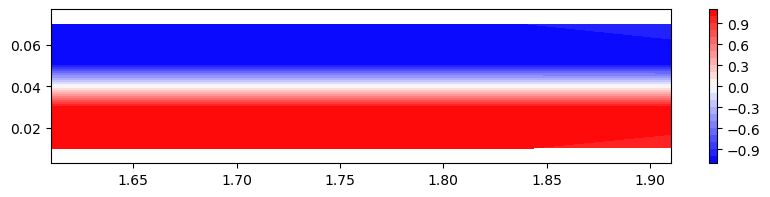

(-1.0105724482181604, 1.0106605345137798)

In [13]:
x = 1.61:0.10:2.00
y = 0.01:0.02:0.08
E = evaluate(WhitneyRectangleElement(), e0, dof, x, y, n, m, lx, ly, el2ed, el2edd)
normE  = @. sqrt(E[:, :, 1]^2 + E[:, :, 2]^2)
xx, yy = meshgrid(x, y);

figure(figsize=(10, 2))
contourf(xx', yy', E[:, :, 2], cmap=PyPlot.get_cmap("bwr"), levels=20)
axis("equal"); colorbar();
extrema(E[:,:,2])

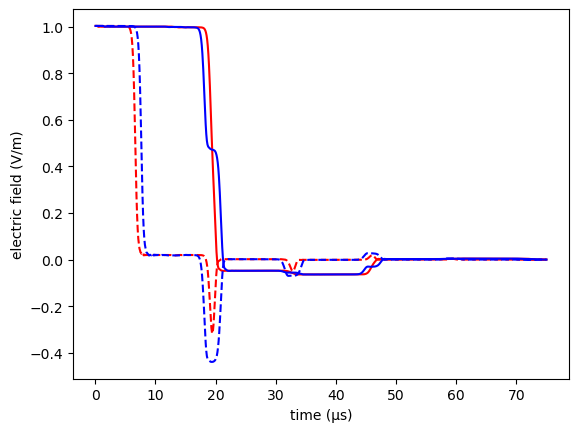

PyObject Text(24.000000000000007, 0.5, 'electric field (V/m)')

In [14]:
using PyPlot

ts = 1e9Δt * collect(1:nt)
plot(ts, res[:, 3, 1, 2], "r-")
plot(ts,-res[:, 3, 6, 2], "r--")
plot(ts, res[:, 9, 1, 2], "b-")
plot(ts,-res[:, 9, 6, 2], "b--")
xlabel("time (μs)")
ylabel("electric field (V/m)")

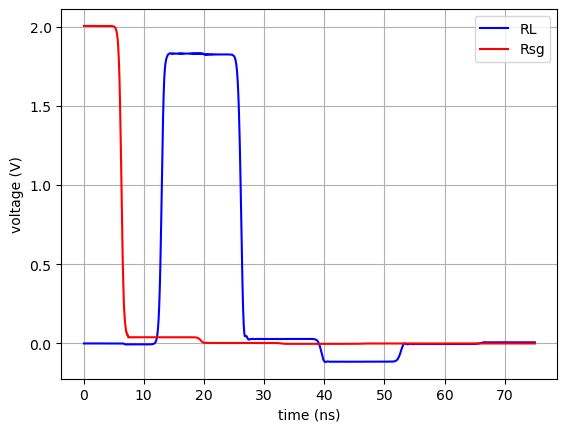

PyObject <matplotlib.legend.Legend object at 0x7f7cb637bf70>

In [15]:
ts = 1e9Δt * collect(1:nt)

xlabel("time (ns)")
grid()
plot(ts, vRL, "b-")
plot(ts,-vRsg, "r-")
ylabel("voltage (V)")
legend(["RL", "Rsg"])